In [1]:
!pip install pyDOE

In [2]:
import sys
# Include the path that contains a number of files that have txt files containing solutions to the Burger's problem.
# sys.path.insert(0,'../../Utilities/')

import os
os.getcwd()

# Import required modules
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.io
from scipy.interpolate import griddata
from scipy.integrate import solve_ivp
from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


np.random.seed(1234)
torch.manual_seed(1234)

Let us obtain the high fidelity solution for the Lorenz attractor

$\frac{dx}{dt} = \sigma(y-x)$

$\frac{dy}{dt} = x(\rho-z) - y$

$\frac{dy}{dt} = xy - \beta z$

A stable system is obtained when $\sigma = 10$, $\beta = \frac{8}{3}$, and $\rho = 28$.


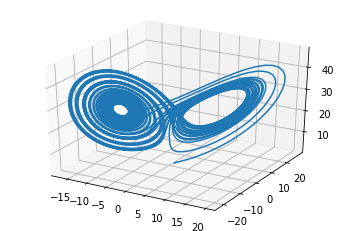

In [3]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0

def f(t, state):
  x, y, z = state  # Unpack the state vector
  return sigma * (y - x), x * (rho - z) - y, x * y - beta * z  # Derivatives

state0 = [1.0, 1.0, 1.0]
t_span = [0, 40.0]

states = solve_ivp(f, t_span, state0, t_eval = np.linspace(0,40.0,4001))

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states.y[0,:], states.y[1,:], states.y[2,:])
plt.draw()
plt.show()

The above shows the solution for the Lorenz attractor. The question now is can a PINN predict this behaviour gievn some sparese data points? It is clear here that this is strictly an IVP and not a mixed IVP + BVP. Thus, we may need additional points within the domain to ensure that the predictions are right.

Within the PINN, we have a state ```u``` that is a function of space **X** and time **t**. ```u``` is governed by a physics equation (eg. Burgers equation). In the Lorenz attractor, we have three states to track- ```x```, ```y```, and ```z```. Each of these states are a function of **t**.

In [4]:
class PhysicsInformedNN:
    # Initialize the class
    """
    This class defined the Physics Informed Neural Network. The class is first initialized by the __init__ function. Additional functions related to the class are also defined subsequently.
    """

    def __init__(self, t, X, t_f, layers, lb, ub, sigma, beta, rho, epochs):


        """
        The initialisation takes:
        t: Location of training points (contains t)
        X: Data at the training point location (x, y, z)
        X_u and u form the labelled, ordered training set pair for learning.
        t_f: Locations for additional training based on physics (in this case the ODE).
        sigma, beta, rho: Additional problem based parameters.
        epoch: number of epochs to run the learning.
        """

        # Defining the lower and upper bound of the domain.
        self.lb = lb
        self.ub = ub
        self.epochs = epochs

        # X_u = 2.0 * (X_u - self.lb)/(self.ub - self.lb) - 1.0
        # X_f = 2.0 * (X_f - self.lb)/(self.ub - self.lb) - 1.0

        #$ Define the initial conditions for x, y, z and t for MSE loss
        self.t = torch.tensor(t).float()
        self.t.requires_grad = True

        #$ Define the initial conditions for X and t for the field loss
        self.t_f = torch.tensor(t_f).float()
        self.t_f.requires_grad = True

        # Declaring the field for the variable to be solved for
        self.X = torch.tensor(X).float()
        self.X_true = torch.tensor(X).float()

        # Declaring the number of layers in the Neural Network
        self.layers = layers
        # Defininf the diffusion constant in the problem (?)
        self.sigma = sigma
        self.beta = beta
        self.rho = rho

        # Create the structure of the neural network here, or build a function below to build the architecture and send the model here.

        self.model = self.neural_net(layers)

        # Define the initialize_NN function to obtain the initial weights and biases for the network.
        self.model.apply(self.initialize_NN)

        # Select the optimization method for the network. Currently, it is just a placeholder.

        self.optimizer = torch.optim.SGD(self.model.parameters(), lr = 0.01)

        self.losses = []
        # train(model,epochs,self.x_u_tf,self.t_u_tf,self.x_f_tf,self.t_f_tf,self.u_tf)

    def neural_net(self, layers):
        """
        A function to build the neural network of the required size using the weights and biases provided. Instead of doing this, can we use a simple constructor method and initalize them post the construction? That would be sensible and faster.
        """
        model = nn.Sequential()
        for l in range(0, len(layers) - 1):
            model.add_module("layer_"+str(l), nn.Linear(layers[l],layers[l+1], bias=True))
            if l != len(layers) - 2:
                model.add_module("tanh_"+str(l), nn.Tanh())

        return model


    def initialize_NN(self, m):
        """
        Initialize the neural network with the required layers, the weights and the biases. The input "layers" in an array that contains the number of nodes (neurons) in each layer.
        """

        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            # print(m.weight)


    def net_X(self, t_point):
        """
        Forward pass through the network to obtain the U field.
        """

        X = self.model(t_point)
        return X


    def net_f(self, t_point):
        X = self.net_X(t_point)
        dX = torch.autograd.grad(X[:,0], t_point, grad_outputs = torch.ones([len(t_point)], dtype = torch.float), create_graph = True)
        dY = torch.autograd.grad(X[:,1], t_point, grad_outputs = torch.ones([len(t_point)], dtype = torch.float), create_graph = True)
        dZ = torch.autograd.grad(X[:,2], t_point, grad_outputs = torch.ones([len(t_point)], dtype = torch.float), create_graph = True)

        # This is the losses from the 3 ODEs
        f1 = dX[0].squeeze() - self.sigma * (X[:,1] - X[:,0])
        f2 = dY[0].squeeze() - X[:,0] * (self.rho - X[:,2]) + X[:,1]
        f3 = dZ[0].squeeze() - X[:,0] * X[:,1] + self.beta * X[:,2]

        return [f1,f2,f3]

    def calc_loss(self, X_pred, X_true, f_pred):
        X_error = X_pred - X_true
        loss_u = torch.mean(torch.mul(X_error, X_error))
        loss_f1 = torch.mean(torch.mul(f_pred[0], f_pred[0]))
        loss_f2 = torch.mean(torch.mul(f_pred[1], f_pred[1]))
        loss_f3 = torch.mean(torch.mul(f_pred[2], f_pred[2]))
        loss_f = loss_f1 + loss_f2 + loss_f3
        losses = loss_u + loss_f
        # print('Loss: %.4e, U_loss: %.4e, F_loss: %.4e' %(losses, loss_u, loss_f))
        return losses


    def set_optimizer(self,optimizer):
        self.optimizer = optimizer


    def train(self):

        for epoch in range(0,self.epochs):
            # Now, one can perform a forward pass through the network to predict the value of u and f for various locations of x and at various times t. The function to call here is net_u and net_f.

            # Here it is crucial to remember to provide x and t as columns and not as rows. Concatenation in the prediction step will fail otherwise.

            X_pred = self.net_X(self.t)
            f_pred = self.net_f(self.t_f)

            # Now, we can define the loss of the network. The loss here is broken into two components: one is the loss due to miscalculating the predicted value of u, the other is for not satisfying the physical governing equation in f which must be equal to 0 at all times and all locations (strong form).

            loss = self.calc_loss(X_pred, self.X_true, f_pred)
            if epoch  % 100 == 0:
              print('Loss: %.4e' %(loss))
            self.losses.append(loss.detach().numpy())

            # Clear out the previous gradients
            self.optimizer.zero_grad()

            # Calculate the gradients using the backward() method.

            loss.backward() # Here, a tensor may need to be passed so that the gradients can be calculated.

            # Optimize the parameters through the optimization step and the learning rate.

            self.optimizer.step()

            # Repeat the prediction, calculation of losses, and optimization a number of times to optimize the network.

    # def closure(self):
    #     self.optimizer.zero_grad()
    #     u_pred = self.net_u(self.x_u, self.t_u)
    #     f_pred = self.net_f(self.x_f, self.t_f)
    #     loss = self.calc_loss(u_pred, self.u_true, f_pred)
    #     loss.backward()
    #     return loss


In [5]:
if __name__ == "__main__":

    sigma = 10.0
    beta = 8/3
    rho = 28.0
    n_epochs = 100

    N_u = 100
    N_f = 1000

    # Layer Map

    layers = [1, 20, 20, 20, 20, 20, 20, 20, 20, 3]

    # data = scipy.io.loadmat('burgers_shock.mat')

    # t = data['t'].flatten()[:,None]
    # x = data['x'].flatten()[:,None]
    # Exact = np.real(data['usol']).T

    X = states.y.T
    t = states.t

    # X, T = np.meshgrid(x,t)
    # X_star = np.hstack((X.flatten()[:,None],T.flatten()[:,None]))
    # u_star = Exact.flatten()[:,None]

    # Domain bounds
    lb = t.min(0)
    ub = t.max(0)

    # T[0:1,:].T
    t1 = t[0] # Initial Conditions (time)
    X1 = X[0,:] # Initial Condition (state)
    # xx2 = np.hstack((X[:,0:1], T[:,0:1])) # Boundary Condition 1
    # uu2 = Exact[:,0:1]
    # xx3 = np.hstack((X[:,-1:], T[:,-1:])) # Boundary Condition 2
    # uu3 = Exact[:,-1:]

    # X_u_train = np.vstack([xx1, xx2, xx3])
    t_train = [t1]
    t_f_train = lb + (ub-lb)*lhs(1,N_f)
    t_f_train = np.vstack((t_f_train, t_train))
    X_train = X1

    idx = np.random.choice(t.shape[0], N_u, replace=False)
    t_train = np.resize(np.append(t1,t[idx]),[101,1])
    X_train = np.resize(np.append(X1,X[idx,:]),[101,3])

    pinn = PhysicsInformedNN(t_train, X_train, t_f_train, layers, lb, ub,
                             sigma, beta, rho, n_epochs)

In [6]:
pinn.model

Sequential(
  (layer_0): Linear(in_features=1, out_features=20, bias=True)
  (tanh_0): Tanh()
  (layer_1): Linear(in_features=20, out_features=20, bias=True)
  (tanh_1): Tanh()
  (layer_2): Linear(in_features=20, out_features=20, bias=True)
  (tanh_2): Tanh()
  (layer_3): Linear(in_features=20, out_features=20, bias=True)
  (tanh_3): Tanh()
  (layer_4): Linear(in_features=20, out_features=20, bias=True)
  (tanh_4): Tanh()
  (layer_5): Linear(in_features=20, out_features=20, bias=True)
  (tanh_5): Tanh()
  (layer_6): Linear(in_features=20, out_features=20, bias=True)
  (tanh_6): Tanh()
  (layer_7): Linear(in_features=20, out_features=20, bias=True)
  (tanh_7): Tanh()
  (layer_8): Linear(in_features=20, out_features=3, bias=True)
)

In [7]:
pinn.set_optimizer(torch.optim.Adam(pinn.model.parameters(), lr = 1e-3))

Loss: 2.8283e+02
Loss: 2.4330e+02
Loss: 2.4327e+02
Loss: 2.4325e+02
Loss: 2.4323e+02
Loss: 2.4321e+02
Loss: 2.4319e+02
Loss: 2.4317e+02
Loss: 2.4313e+02
Loss: 2.4310e+02


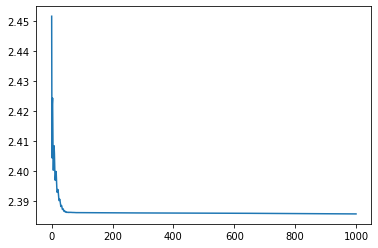

In [8]:
for _ in range(10):
  pinn.train()

plt.plot(np.linspace(0,len(pinn.losses),num=len(pinn.losses)),np.log10(pinn.losses))

In [9]:
states_pred = pinn.model(torch.tensor(np.resize(np.linspace(0,1,4001),[4001,1]),dtype=torch.float)).detach().numpy()

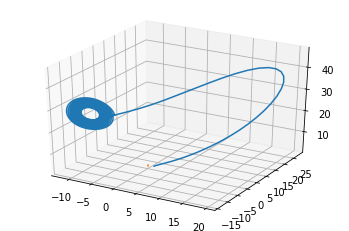

In [10]:
t_max = 1000
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(states.y[0,:t_max], states.y[1,:t_max], states.y[2,:t_max])
ax.plot(states_pred[:t_max,0], states_pred[:t_max,1], states_pred[:t_max,2])
plt.draw()
plt.show()

In [11]:
states_pred[:,0]

array([ 0.0113567 ,  0.0113578 ,  0.01135902, ..., -0.0031489 ,
       -0.00315113, -0.00315346], dtype=float32)